In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilingual-datasets/features.csv
/kaggle/input/multilingual-datasets/final_merged_data.csv
/kaggle/input/multilingual-datasets/final_datasets.csv
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/merged_data.csv
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/eng476.png
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/meme_184.png
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/tangaila (166).jpg
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/Image- (178).jpg
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/Image- (2026).jpg
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/52691.png
/kaggle/input/multilingual-datasets/multimeme_dataset/multimeme_dataset/image_dataset/Bangla Thug Life (374).jpg
/kaggle/input/multilingual-datase

Dataset loaded with shape: (25600, 11)

=== Dataset Analysis ===
Dataset shape: (25600, 11)
Column names: ['ids', 'name', 'text', 'label', 'id', 'gender', 'age', 'age_bucket', 'dominant_emotion', 'dominant_race', 'translated_text']

Label distribution:
label
1    17388
0     8212
Name: count, dtype: int64

Sample translated_text entries:
1: Amma: HSC It's coming , from now on and , I'll kill all your   Me: mobile laptops          ...
2: WHEN YOUR COUSINS TAKES YOU TO THE DHAN KHET AND SHOWS HIS KALO BONDUK...
3: WHEN HE SAID 10 MINUTES BUT IT WAS ONLY 2 MINUTES...
4: SHE - I CAN'T BE WITH YOU   - I want you to ...
5: When you Teacher say   "tell the truth, then don't say anything"  brother, what a fool's got in my ?...

Missing values by column:
ids                     0
name                    0
text                  285
label                   0
id                  18554
gender              18554
age                 18554
age_bucket          18554
dominant_emotion    18554
dominant_r

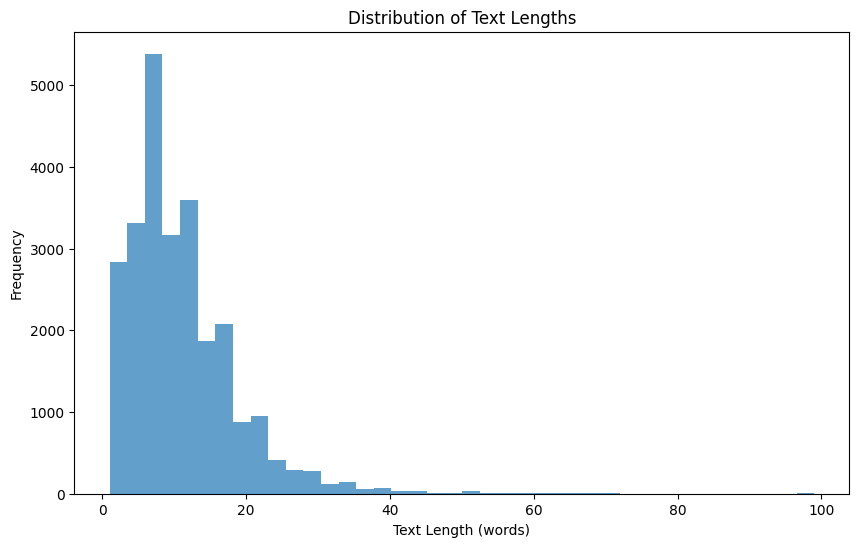

Train set: 17920, Validation set: 3840, Test set: 3840
Training SVM model...


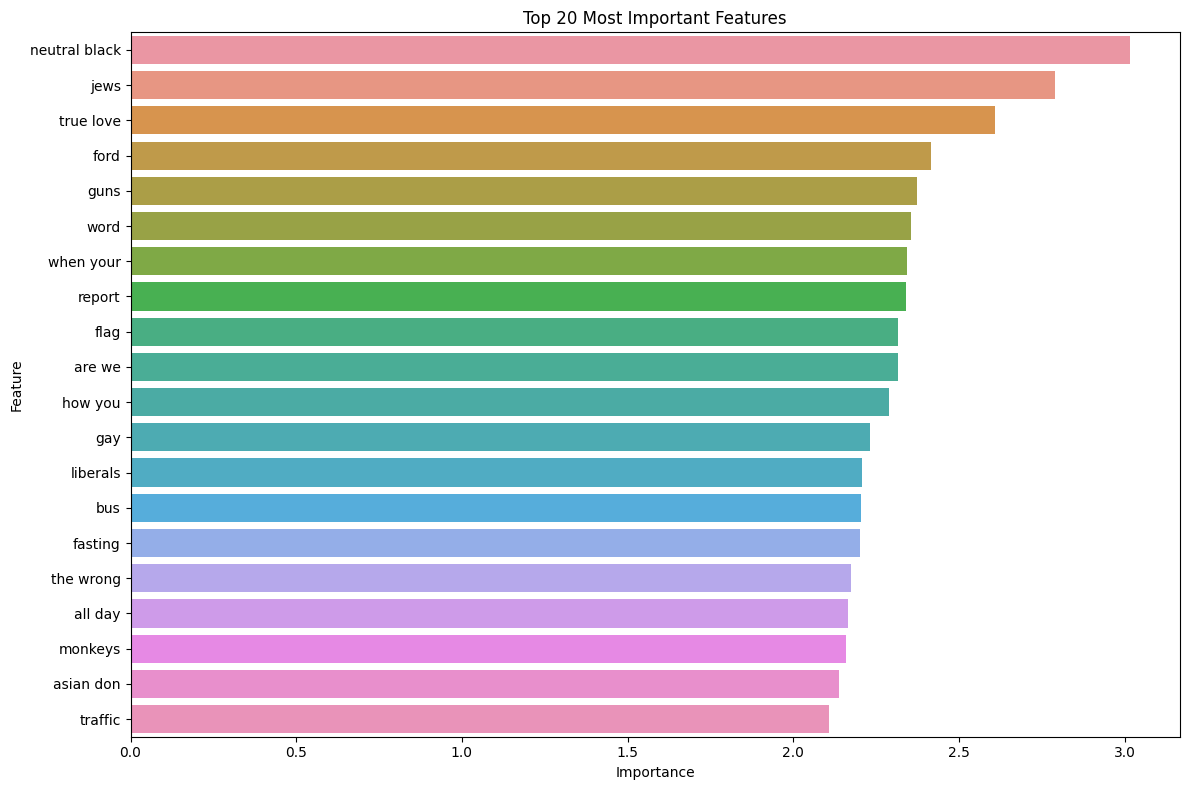


Top 10 most important features:
            Feature  Importance
2865  neutral black    3.016291
2038           jews    2.789350
4327      true love    2.610019
1359           ford    2.415633
1564           guns    2.373583
4776           word    2.356454
4597      when your    2.344160
3385         report    2.339962
1314           flag    2.316775
344          are we    2.315488

Evaluating model on test set...
Test Accuracy: 0.7115

Confusion Matrix:
[[ 413  819]
 [ 289 2319]]

Classification Report:
              precision    recall  f1-score   support

 Non-Harmful       0.59      0.34      0.43      1232
     Harmful       0.74      0.89      0.81      2608

    accuracy                           0.71      3840
   macro avg       0.66      0.61      0.62      3840
weighted avg       0.69      0.71      0.69      3840



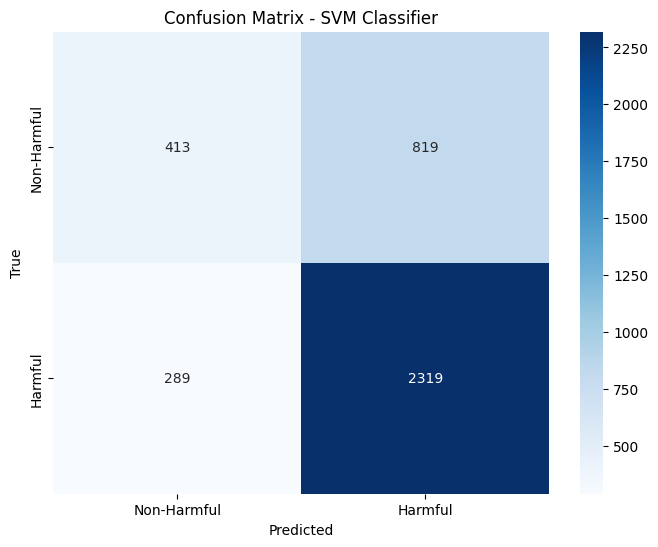

SVM model saved as 'svm_harmful_content_classifier.pkl'
SVM model training and evaluation complete!


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Load dataset
df = pd.read_csv('/kaggle/input/multilingual-datasets/final_datasets.csv')
print(f"Dataset loaded with shape: {df.shape}")

# Function to analyze dataset
def analyze_dataset(df):
    """
    Analyze the dataset to understand its structure and content.
    """
    print("\n=== Dataset Analysis ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Column names: {df.columns.tolist()}")
    
    # Check label distribution
    print("\nLabel distribution:")
    label_counts = df['label'].value_counts()
    print(label_counts)
    
    # Show sample text entries
    print("\nSample translated_text entries:")
    for i, text in enumerate(df['translated_text'].head(5)):
        print(f"{i+1}: {text[:100]}...")
    
    # Check for missing values
    print("\nMissing values by column:")
    print(df.isnull().sum())
    
    # Analyze text lengths
    df['text_length'] = df['translated_text'].apply(lambda x: len(str(x).split()))
    print("\nText length statistics:")
    print(f"Mean: {df['text_length'].mean():.2f} words")
    print(f"Median: {df['text_length'].median()} words")
    print(f"Min: {df['text_length'].min()} words")
    print(f"Max: {df['text_length'].max()} words")
    
    # Plot text length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['text_length'].clip(upper=200), bins=40, alpha=0.7)
    plt.xlabel('Text Length (words)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Text Lengths')
    plt.savefig('text_length_distribution.png')
    plt.show()
    
    return df

# Text preprocessing function
def preprocess_text_features(dataframe):
    """
    Combine text features into a single feature for vectorization
    """
    # Combine all relevant text fields
    dataframe['combined_text'] = dataframe.apply(
        lambda row: f"{row['gender']} {row['age']} {row['age_bucket']} "
                    f"{row['dominant_emotion']} {row['dominant_race']} {row['translated_text']}",
        axis=1
    )
    return dataframe

# Function to evaluate model and display metrics
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and display performance metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Non-Harmful', 'Harmful'])
    
    print(f'Test Accuracy: {accuracy:.4f}')
    print('\nConfusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Harmful', 'Harmful'], 
                yticklabels=['Non-Harmful', 'Harmful'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - SVM Classifier')
    plt.savefig('svm_confusion_matrix.png')
    plt.show()
    
    return accuracy, conf_matrix, class_report

# Function to perform categorical encoding
def encode_categorical_features(train_df, valid_df, test_df):
    """
    One-hot encode categorical features
    """
    categorical_features = ['gender', 'age_bucket', 'dominant_emotion', 'dominant_race']
    
    # Initialize encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit encoder on training data
    encoder.fit(train_df[categorical_features])
    
    # Transform each dataset
    train_encoded = encoder.transform(train_df[categorical_features])
    valid_encoded = encoder.transform(valid_df[categorical_features])
    test_encoded = encoder.transform(test_df[categorical_features])
    
    # Get feature names
    feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Convert to DataFrames
    train_cat_df = pd.DataFrame(train_encoded, columns=feature_names, index=train_df.index)
    valid_cat_df = pd.DataFrame(valid_encoded, columns=feature_names, index=valid_df.index)
    test_cat_df = pd.DataFrame(test_encoded, columns=feature_names, index=test_df.index)
    
    # Add the encoded features to the original dataframes
    train_df = pd.concat([train_df, train_cat_df], axis=1)
    valid_df = pd.concat([valid_df, valid_cat_df], axis=1)
    test_df = pd.concat([test_df, test_cat_df], axis=1)
    
    return train_df, valid_df, test_df, feature_names

# Main execution
def main():
    global df
    
    # Analyze the dataset
    df = analyze_dataset(df)
    
    # Preprocess to combine text features
    df = preprocess_text_features(df)
    
    # Split dataset
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print(f"Train set: {len(train_df)}, Validation set: {len(valid_df)}, Test set: {len(test_df)}")
    
    # Extract features and labels
    X_train = train_df['combined_text']
    X_valid = valid_df['combined_text']
    X_test = test_df['combined_text']
    
    y_train = train_df['label']
    y_valid = valid_df['label']
    y_test = test_df['label']
    
    # Create pipeline with TF-IDF and SVM
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('svm', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
    ])
    
    print("Training SVM model...")
    
    # Train the model using both training and validation data for a more robust model
    X_train_combined = pd.concat([X_train, X_valid])
    y_train_combined = pd.concat([y_train, y_valid])
    
    pipeline.fit(X_train_combined, y_train_combined)
    
    # Feature importance analysis (for linear kernel)
    # Fix for CSR matrix error - convert to dense array first
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    coefficients = pipeline.named_steps['svm'].coef_.toarray().flatten()  # Convert to dense array first
    
    # Create a DataFrame for the feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients)
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.savefig('svm_feature_importance.png')
    plt.show()
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
    # Evaluate final model on test set
    print("\nEvaluating model on test set...")
    accuracy, conf_matrix, class_report = evaluate_model(pipeline, X_test, y_test)
    
    # Save the model
    import joblib
    joblib.dump(pipeline, 'svm_harmful_content_classifier.pkl')
    print("SVM model saved as 'svm_harmful_content_classifier.pkl'")
    
    print("SVM model training and evaluation complete!")

# Version with categorical features
def main_with_categorical_features():
    global df
    
    # Analyze the dataset
    df = analyze_dataset(df)
    
    # Preprocess to combine text features
    df = preprocess_text_features(df)
    
    # Split dataset
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print(f"Train set: {len(train_df)}, Validation set: {len(valid_df)}, Test set: {len(test_df)}")
    
    # Encode categorical features
    train_df, valid_df, test_df, cat_feature_names = encode_categorical_features(
        train_df, valid_df, test_df
    )
    
    # Create text feature pipeline
    text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)))
    ])
    
    # Transform text data
    X_train_text = text_pipeline.fit_transform(train_df['combined_text'])
    X_valid_text = text_pipeline.transform(valid_df['combined_text'])
    X_test_text = text_pipeline.transform(test_df['combined_text'])
    
    # Convert sparse matrices to dense arrays
    X_train_text_dense = X_train_text.toarray()
    X_valid_text_dense = X_valid_text.toarray()
    X_test_text_dense = X_test_text.toarray()
    
    # Get categorical features
    X_train_cat = train_df[cat_feature_names].values if len(cat_feature_names) > 0 else np.empty((len(train_df), 0))
    X_valid_cat = valid_df[cat_feature_names].values if len(cat_feature_names) > 0 else np.empty((len(valid_df), 0))
    X_test_cat = test_df[cat_feature_names].values if len(cat_feature_names) > 0 else np.empty((len(test_df), 0))
    
    # Combine text and categorical features
    X_train_combined = np.hstack((X_train_text_dense, X_train_cat))
    X_valid_combined = np.hstack((X_valid_text_dense, X_valid_cat))
    X_test_combined = np.hstack((X_test_text_dense, X_test_cat))
    
    # Extract labels
    y_train = train_df['label']
    y_valid = valid_df['label']
    y_test = test_df['label']
    
    # Combine train and validation sets for final model
    X_train_valid_combined = np.vstack((X_train_combined, X_valid_combined))
    y_train_valid = pd.concat([y_train, y_valid])
    
    # Create and train SVM model
    print("Training SVM model with combined features...")
    svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    svm_model.fit(X_train_valid_combined, y_train_valid)
    
    # Evaluate on test set
    print("\nEvaluating model on test set...")
    accuracy, conf_matrix, class_report = evaluate_model(svm_model, X_test_combined, y_test)
    
    # Save the model and feature extraction pipeline for future use
    import joblib
    model_data = {
        'text_pipeline': text_pipeline,
        'cat_feature_names': cat_feature_names,
        'svm_model': svm_model
    }
    joblib.dump(model_data, 'svm_harmful_content_classifier_with_features.pkl')
    print("SVM model saved as 'svm_harmful_content_classifier_with_features.pkl'")
    
    print("SVM model training with combined features complete!")

if __name__ == "__main__":
    # Run the basic SVM implementation
    main()
    
    # Uncomment to run the version with categorical features
    # main_with_categorical_features()